In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [3]:
stream_df = pd.read_csv("data/tracks_by_time_and_streams.csv")

In [4]:
stream_df = stream_df.drop(columns="Unnamed: 0")

In [6]:
stream_df

,master_metadata_track_name,master_metadata_album_artist_name,ms_played,stream_count
0,"""A New Game"" - Da Riffs Madden Mix",Sam Spence,19613,2
1,"""Casta Diva"" from Norma",Bellini,2856,1
2,"""I just want to make buscuits with papa"" (dial...",Irons In the Fire,19839,3
3,"""In The Hall Of The Mountain King"" from Peer G...",London Symphony Orchestra,149050,1
4,"""Magnificent Eleven"" - Da Riffs Madden Mix",Sam Spence,59558,3
...,...,...,...,...
27861,한 폭의 그림 Paradise,S.E.S.,355106,11
27862,해변의 여인,COOL,3575,1
27863,행복 (Happiness),Red Velvet,3094901,26
27864,힐끔힐끔 Peep,ONE,358445,3


In [7]:
top_artists = stream_df.groupby("master_metadata_album_artist_name").agg({
    'ms_played': 'sum',
    'stream_count': 'count'
})

top_artists = top_artists.sort_values(by="ms_played", ascending=False)

In [9]:
top_artists.head(20)

,ms_played,stream_count
master_metadata_album_artist_name,,
Last Dinosaurs,230020660,61
Reality Club,148565217,38
Red Velvet,142951129,100
Saint Motel,137171637,52
Two Door Cinema Club,112847908,78
Kero Kero Bonito,104531976,63
Sergei Rachmaninoff,84571144,68
Drake,83828861,83
Pyotr Ilyich Tchaikovsky,80444610,149


In [10]:
stream_df

,master_metadata_track_name,master_metadata_album_artist_name,ms_played,stream_count
0,"""A New Game"" - Da Riffs Madden Mix",Sam Spence,19613,2
1,"""Casta Diva"" from Norma",Bellini,2856,1
2,"""I just want to make buscuits with papa"" (dial...",Irons In the Fire,19839,3
3,"""In The Hall Of The Mountain King"" from Peer G...",London Symphony Orchestra,149050,1
4,"""Magnificent Eleven"" - Da Riffs Madden Mix",Sam Spence,59558,3
...,...,...,...,...
27861,한 폭의 그림 Paradise,S.E.S.,355106,11
27862,해변의 여인,COOL,3575,1
27863,행복 (Happiness),Red Velvet,3094901,26
27864,힐끔힐끔 Peep,ONE,358445,3


In [13]:
X = stream_df[['stream_count', 'ms_played']].copy()
X['log_plays'] = np.log1p(X['stream_count'])
X['log_ms_played'] = np.log1p(X['ms_played'])

# Step 2: Extract just the log-transformed features for clustering
features = X[['log_plays', 'log_ms_played']]

# Step 3: Standardize the features (important for k-means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

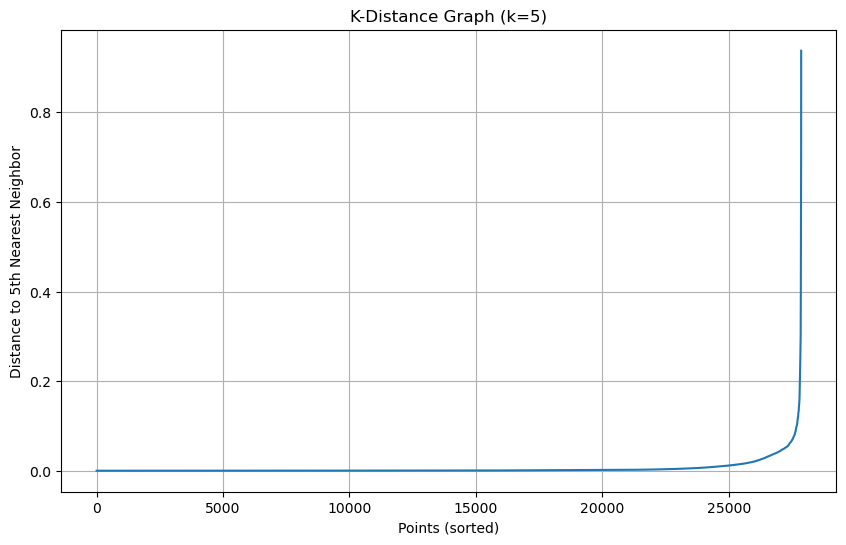

In [14]:
# Using the same scaled features we prepared for k-means
# Remember, these are the log-transformed and standardized features

# Find optimal eps parameter using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort distances to the 5th nearest neighbor
distances = np.sort(distances[:, 4])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points (sorted)')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.title('K-Distance Graph (k=5)')
plt.grid(True)
plt.show()

Cluster distribution:
 1    16616
 0     4193
 5     3478
 2     1781
 6      933
 4      575
 3      243
-1       31
 7       16
Name: count, dtype: int64


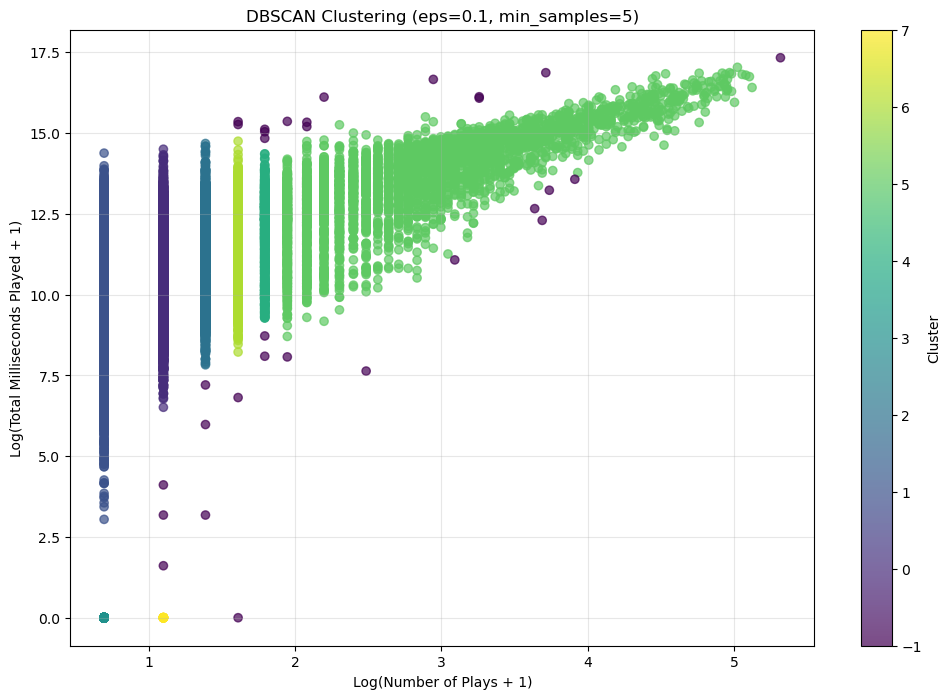

In [15]:
# Try DBSCAN with eps=0.1 and min_samples=5
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_features)

# Check cluster distribution
print("Cluster distribution:")
print(pd.Series(dbscan_clusters).value_counts())

# Visualize clusters
plt.figure(figsize=(12, 8))
plt.scatter(X['log_plays'], X['log_ms_played'], c=dbscan_clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('Log(Number of Plays + 1)')
plt.ylabel('Log(Total Milliseconds Played + 1)')
plt.title('DBSCAN Clustering (eps=0.1, min_samples=5)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
stream_df['dbscan_cluster'] = dbscan_clusters

total_range = list(range(19))


# Analyze a few key clusters
for cluster_id in total_range:  # Top 4 clusters by size
    cluster_data = stream_df[stream_df['dbscan_cluster'] == cluster_id]
    
    print(f"\nDBSCAN Cluster {cluster_id} (Size: {len(cluster_data)})")
    print(f"  Plays range: {cluster_data['stream_count'].min()} to {cluster_data['stream_count'].max()}")
    print(f"  MS played range: {cluster_data['ms_played'].min()} to {cluster_data['ms_played'].max()}")
    print(f"  Average plays: {cluster_data['stream_count'].mean():.2f}")
    print(f"  Average duration (minutes): {(cluster_data['ms_played'].mean() / 60000):.2f}")


DBSCAN Cluster 0 (Size: 4193)
  Plays range: 2 to 2
  MS played range: 673 to 1983815
  Average plays: 2.00
  Average duration (minutes): 1.80

DBSCAN Cluster 1 (Size: 16616)
  Plays range: 1 to 1
  MS played range: 20 to 1757936
  Average plays: 1.00
  Average duration (minutes): 0.84

DBSCAN Cluster 2 (Size: 1781)
  Plays range: 3 to 3
  MS played range: 2506 to 2367720
  Average plays: 3.00
  Average duration (minutes): 2.90

DBSCAN Cluster 3 (Size: 243)
  Plays range: 1 to 1
  MS played range: 0 to 0
  Average plays: 1.00
  Average duration (minutes): 0.00

DBSCAN Cluster 4 (Size: 575)
  Plays range: 5 to 5
  MS played range: 10652 to 1720000
  Average plays: 5.00
  Average duration (minutes): 4.44

DBSCAN Cluster 5 (Size: 3478)
  Plays range: 6 to 167
  MS played range: 6035 to 25039302
  Average plays: 21.19
  Average duration (minutes): 27.74

DBSCAN Cluster 6 (Size: 933)
  Plays range: 4 to 4
  MS played range: 3726 to 2543668
  Average plays: 4.00
  Average duration (minutes)

In [20]:
stream_df.loc[stream_df['dbscan_cluster'] == -1].sort_values(by='ms_played', ascending=False).head(50)

,master_metadata_track_name,master_metadata_album_artist_name,ms_played,stream_count,dbscan_cluster
11460,If You Want To,beabadoobee,33666764,203,-1
20434,"Singing Didgeridoo and Sound of Nature, Forest...",Didgeridoo Aboriginal Dreamtime,21180901,40,-1
5889,Didgeridoo Dreamtime with Gentle Healing Water...,Didgeridoo Aboriginal Dreamtime,17221294,18,-1
810,"Adagio for Strings, Op. 11",Samuel Barber,10058861,25,-1
1795,Australia - Traditional Didgeridoo Australian ...,Didgeridoo Aboriginal Dreamtime,9952979,8,-1
17592,"Piano Concerto No. 2 in C Minor, Op. 18: 2. Ad...",Sergei Rachmaninoff,9634111,25,-1
17601,"Piano Concerto No. 3 in D Minor, Op. 30: I. Al...",Sergei Rachmaninoff,4694563,6,-1
5888,Didgeridoo Aboriginal Music with Babbling Broo...,Didgeridoo Aboriginal Dreamtime,4655085,4,-1
22223,"Symphony No. 2 in E Minor, Op. 27: III. Adagio",Sergei Rachmaninoff,4568223,7,-1
22227,"Symphony No. 3 in A Minor, Op. 44: I. Lento - ...",Sergei Rachmaninoff,4259732,4,-1
